In [16]:
import pandas as pd
import numpy as np
import re

In [17]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('max_colwidth', 800)

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# Load the dataframes
test_df = pd.read_csv('data/cleaned-input.test.tsv', sep='\t', low_memory=False)
training_df = pd.read_csv('data/cleaned-input.training.tsv', sep='\t', low_memory=False)

In [20]:
import eda_tools as et
import data_munging_tools as dmt
import impute_eval as ie
import model_fitting_tools as mft

In [21]:
TARGET_1 = 'production_liquid_90'
TARGET_2 = 'production_liquid_180'
TARGET_3 = 'production_liquid_365'

In [22]:
def short_info(df):
    name =[x for x in globals() if globals()[x] is df]
    print "\n", "*"*50
    print "dataframe name: {}".format(name)
    print "shape: {}".format(df.shape)
    print "index: {}".format(df.index)
    print "Nulls exist: {}".format(np.any(df.isnull()))

# EDA

In [23]:
explore_df = pd.DataFrame.from_csv('data/cleaned-input.training.tsv', sep='\t')

In [24]:
column_summaries = et.column_summaries(explore_df)

In [25]:
column_summaries.head()

,dtype,unq_val_ct,percent_nans
CountyName,object,15,0.000000
CurrentOperator,object,56,0.000000
CurrentWellName,object,6529,0.000000
DFElev,float64,3,99.969367
FieldName,object,333,0.000000


In [26]:
data_dict = pd.read_html('data/Attribute+Descriptions.html')
data_dict = data_dict[0]

In [27]:
data_dict.head()

,Field Name,Category,Description
0,FileNo,Identifier,North Dakota specific identifier for the well
1,CountyName,Location,Name of the County where the well is located
2,CurrentOperator,NaN,Name of the Company that operates the well
3,CurrentWellName,NaN,"Name of the well; essentially free text, naming conventions vary by operator"
4,DFElev,NaN,Drilling floor elevation


In [28]:
data_dict_master = column_summaries.join(data_dict.set_index("Field Name"))
data_dict_master

,dtype,unq_val_ct,percent_nans,Category,Description
CountyName,object,15,0.000000,Location,Name of the County where the well is located
CurrentOperator,object,56,0.000000,NaN,Name of the Company that operates the well
CurrentWellName,object,6529,0.000000,NaN,"Name of the well; essentially free text, naming conventions vary by operator"
DFElev,float64,3,99.969367,NaN,Drilling floor elevation
FieldName,object,333,0.000000,Location,Name of the Field where this well is located
Footages,object,6120,0.000000,NaN,Description of where the well pad is located in relation to the drilling spacing unit
GRElev,float64,860,17.429928,NaN,Graded elevation
KBElev,float64,883,6.019299,NaN,Kelly Bushing elevation
LeaseName,object,3231,0.000000,Location,Name of the Lease associated with this well
LeaseNumber,object,4524,0.045949,Location,Identifier of the Lease assocaited with this well


In [29]:
data_dict[data_dict["Category"] == "Geology"]

,Field Name,Category,Description
13,ProducedPools,Geology,"Which rock formations are producing oil for this well. Same data, but different data source, as 'stimulated_formation'"
23,bakken_isopach_ft,Geology,Thickness of the oil producing Bakken formation at the latitude/longitude of the well
44,stimulated_formation,Geology,Which oil-producing formation was targeted by this well - Middle Bakken or Three Forks. See also 'ProducedPools'


In [30]:
data_dict_master[data_dict_master["unq_val_ct"] <20 ].sort_values("unq_val_ct")

,dtype,unq_val_ct,percent_nans,Category,Description
WellType,object,1,0.000000,NaN,WellType (OG = 'Oil & Gas')
num_pools_produced,int64,2,0.000000,NaN,Number of formations that will produce oil for this well
DFElev,float64,3,99.969367,NaN,Drilling floor elevation
Wellbore,object,3,0.000000,NaN,Type of well (this data set is limited to horizontal and directional)
WellStatus,object,8,0.000000,NaN,Status of the well (A = 'Active')
legs,float64,9,5.100322,NaN,Number of disjoint laterally drilled segments
type_treatment,object,10,17.184868,CompletionDesign,"Type of completion applied to this well (commonly ""sand frac"")"
ProducedPools,object,14,0.168479,Geology,"Which rock formations are producing oil for this well. Same data, but different data source, as 'stimulated_formation'"
bakken_isopach_ft,float64,14,0.000000,Geology,Thickness of the oil producing Bakken formation at the latitude/longitude of the well
CountyName,object,15,0.000000,Location,Name of the County where the well is located


In [31]:
categories = data_dict_master[data_dict_master["unq_val_ct"] <11 ].index.values
categories = categories[categories != "DFElev"]
categories

array(['WellStatus', 'WellType', 'Wellbore', 'legs', 'num_pools_produced',
       'type_treatment'], dtype=object)

In [32]:
data_dict_master[data_dict_master["Category"] == "CompletionDesign"]

,dtype,unq_val_ct,percent_nans,Category,Description
total_lbs_proppant,float64,5536,13.340481,CompletionDesign,"Total amount of proppant used on completion, across all stages"
total_num_stages,int64,74,0.000000,CompletionDesign,Number of stages (segments) the well was stimulated in
total_volume_bbls,float64,5354,15.071221,CompletionDesign,Total amount of liquid used to pressurize the well to fracture the rock
type_treatment,object,10,17.184868,CompletionDesign,"Type of completion applied to this well (commonly ""sand frac"")"


In [33]:
 data_dict_master[data_dict_master["dtype"] == int]

,dtype,unq_val_ct,percent_nans,Category,Description
Section,int64,36,0.0,Location,"Location of the well (Township, Range, Section) are related identifiers, from least- to most- specific"
num_pools_produced,int64,2,0.0,NaN,Number of formations that will produce oil for this well
total_num_stages,int64,74,0.0,CompletionDesign,Number of stages (segments) the well was stimulated in


In [34]:
explore_df.bh_lat.isnull().sum()

333

In [35]:
explore_df[explore_df.CurrentWellName.str.startswith("NELSEN")]

,CountyName,CurrentOperator,CurrentWellName,DFElev,FieldName,Footages,GRElev,KBElev,LeaseName,LeaseNumber,...,std_tvd,stimulated_formation,surface_lat,surface_lng,total_lbs_proppant,total_num_stages,total_volume_bbls,tvd,type_treatment,well_status_date
FileNo,,,,,,,,,,,,,,,,,,,,,
20971,MCKENZIE,XTO ENERGY INC.,NELSEN STATE 24X-33R,NaN,INDIAN HILL,272 FSL 2169 FWL,2188.0,2215.0,NELSEN STATE,24X-33R,...,71.160435,bakken,48.025099,-103.680932,2780580.0,24,61822.0,10748.91,sand frac,2011-09-18
23761,MCKENZIE,XTO ENERGY INC.,NELSEN STATE 24X-33F,NaN,INDIAN HILL,272 FSL 2139 FWL,2188.0,2213.0,NELSEN STATE,24X-33F,...,64.471905,three forks,48.025099,-103.681055,2735748.0,30,112079.0,10802.26,sand frac,2013-02-12


In [36]:
explore_df.query("legs == 4")

,CountyName,CurrentOperator,CurrentWellName,DFElev,FieldName,Footages,GRElev,KBElev,LeaseName,LeaseNumber,...,std_tvd,stimulated_formation,surface_lat,surface_lng,total_lbs_proppant,total_num_stages,total_volume_bbls,tvd,type_treatment,well_status_date
FileNo,,,,,,,,,,,,,,,,,,,,,
20971,MCKENZIE,XTO ENERGY INC.,NELSEN STATE 24X-33R,NaN,INDIAN HILL,272 FSL 2169 FWL,2188.0,2215.0,NELSEN STATE,24X-33R,...,71.160435,bakken,48.025099,-103.680932,2780580.0,24,61822.0,10748.91,sand frac,2011-09-18
21999,BURKE,"PETRO-HUNT, L.L.C.",PRODUCERS CORP 159-94-8A-17-5H,NaN,NORTH TIOGA,275 FNL 1586 FEL,2352.0,2375.0,PRODUCERS CORP,159-94-8A-17-5H,...,168.878733,three forks,48.618005,-102.848955,2884201.0,32,54750.0,9366.06,sand frac,2013-11-10
19323,MCKENZIE,QEP ENERGY COMPANY,THOMPSON 1-29/32H,NaN,GRAIL,400 FNL 1325 FEL,2290.0,2323.0,THOMPSON,1-29/32H,...,185.151130,three forks,47.788616,-102.860602,3285650.0,28,81925.0,10817.88,sand frac,2011-05-20
16854,MCKENZIE,BURLINGTON RESOURCES OIL & GAS COMPANY LP,RINK 24-8H,NaN,PERSHING,300 FSL 1320 FWL,NaN,2413.0,RINK,24-8H,...,108.478514,NaN,47.732681,-102.999352,NaN,1,NaN,11065.47,NaN,2008-11-11
26538,DUNN,OXY USA INC.,MILDRED SADOWSKY 2-11-14H-142-97,NaN,WILLMEN,550 FNL 2167 FWL,2522.0,2546.0,MILDRED SADOWSKY,2-11-14H-142-97,...,118.925161,bakken,47.138360,-102.938841,1744689.0,29,50078.0,10702.52,sand frac,2014-02-08
21570,MOUNTRAIL,"SLAWSON EXPLORATION COMPANY, INC.",SERPENT FEDERAL 1-36-31H,NaN,VAN HOOK,1550 FNL 300 FEL,1882.0,1905.0,SERPENT FEDERAL,1-36-31H,...,188.350763,bakken,47.857940,-102.407894,2574149.0,29,38390.0,10037.18,sand frac,2012-04-28
26454,MCKENZIE,XTO ENERGY INC.,BRODERSON 31X-27G,NaN,SIVERSTON,350 FNL 1680 FEL,2100.0,2125.0,BRODERSON,31X-27G,...,141.545229,three forks,47.788997,-103.203840,3895723.0,30,85129.0,11191.81,sand frac,2014-07-08
17097,DUNN,MARATHON OIL COMPANY,LADONNA KLATT 24-22H,NaN,CHIMNEY BUTTE,500 FSL 1380 FWL,NaN,2373.0,LADONNA KLATT,24-22H,...,152.934542,bakken,47.445875,-102.773398,271460.0,30,19997.0,10889.82,sand frac,2008-05-23
18311,WILLIAMS,STATOIL OIL & GAS LP,WILLISTON 25-36 1-H,NaN,CATWALK,175 FNL 395 FEL,NaN,1872.0,WILLISTON 25-36,1-H,...,195.493386,NaN,48.139257,-103.605119,NaN,1,NaN,10514.26,NaN,2009-12-13


In [37]:
data_dict_master[data_dict_master["dtype"] == float].sort_values("percent_nans", ascending=False)

,dtype,unq_val_ct,percent_nans,Category,Description
DFElev,float64,3,99.969367,NaN,Drilling floor elevation
production_liquid_1825,float64,670,89.753408,Target,Cumulative oil production after 1825 days of operation
production_liquid_730,float64,3713,42.717108,Target,Cumulative oil production after 730 days of operation
GRElev,float64,860,17.429928,NaN,Graded elevation
production_liquid_365,float64,5374,16.311839,Target,Cumulative oil production after 365 days of operation
total_volume_bbls,float64,5354,15.071221,CompletionDesign,Total amount of liquid used to pressurize the well to fracture the rock
total_lbs_proppant,float64,5536,13.340481,CompletionDesign,"Total amount of proppant used on completion, across all stages"
production_liquid_270,float64,5798,9.067238,Target,Cumulative oil production after 270 days of operation
KBElev,float64,883,6.019299,NaN,Kelly Bushing elevation
std_tvd,float64,6197,5.100322,NaN,Standard deviation of all lateral true vertical depth measurements we have for this well


In [38]:
explore_df.Section.head(10)

FileNo
27863    23
20136     1
25780    30
24575    30
22752    34
21606    28
18983    11
23584     5
19712    29
17872    34
Name: Section, dtype: int64

In [39]:
explore_target = explore_df["production_liquid_90"]

In [40]:
#indexes are the file number and does not start with zero.
explore_df.reset_index().loc[0, "Section" ]

23

In [41]:
data_dict_master.sort_values("percent_nans", ascending=False).head(10)

,dtype,unq_val_ct,percent_nans,Category,Description
DFElev,float64,3,99.969367,NaN,Drilling floor elevation
production_liquid_1825,float64,670,89.753408,Target,Cumulative oil production after 1825 days of operation
production_liquid_730,float64,3713,42.717108,Target,Cumulative oil production after 730 days of operation
GRElev,float64,860,17.429928,NaN,Graded elevation
type_treatment,object,10,17.184868,CompletionDesign,"Type of completion applied to this well (commonly ""sand frac"")"
production_liquid_365,float64,5374,16.311839,Target,Cumulative oil production after 365 days of operation
total_volume_bbls,float64,5354,15.071221,CompletionDesign,Total amount of liquid used to pressurize the well to fracture the rock
total_lbs_proppant,float64,5536,13.340481,CompletionDesign,"Total amount of proppant used on completion, across all stages"
stimulated_formation,object,15,12.498085,Geology,Which oil-producing formation was targeted by this well - Middle Bakken or Three Forks. See also 'ProducedPools'
choke_size,object,218,9.542043,NaN,Diameter in inches of the mechanical flow limiter


### Need regex to parse these:

In [42]:
#need regex to parse this later.
explore_df.choke_size.unique()[:50]

array(['41/64', '20/64', '32/64', '48/64', '18/64', '24/64', '12/64',
       '46/64', nan, '14/64', '16/64', '26/64', '40/64', '28/64', '22/64',
       '/64', '44/64', '39/64', '10/64', '38/64', '36/64', '30/64',
       '43/64', '68/64', '42/64', '13/64', '9/64', '0/64', '23/64',
       '176/64', '34/64', '166/64', '25/64', '112/64', '5/16', '36/4',
       '253/64', '64/64', '50/64', '17/64', '63/64', '26/4', '20/4', 'na',
       '181/64', '11/32', '96/64', '52/64', '91/64', '53/64'], dtype=object)

In [43]:
explore_df["Footages"].head()

FileNo
27863     911 FSL  792 FEL
20136    300 FNL  1320 FEL
25780    311 FNL  1795 FWL
24575    310 FNL  2000 FWL
22752    805 FSL  1222 FWL
Name: Footages, dtype: object

### Plots

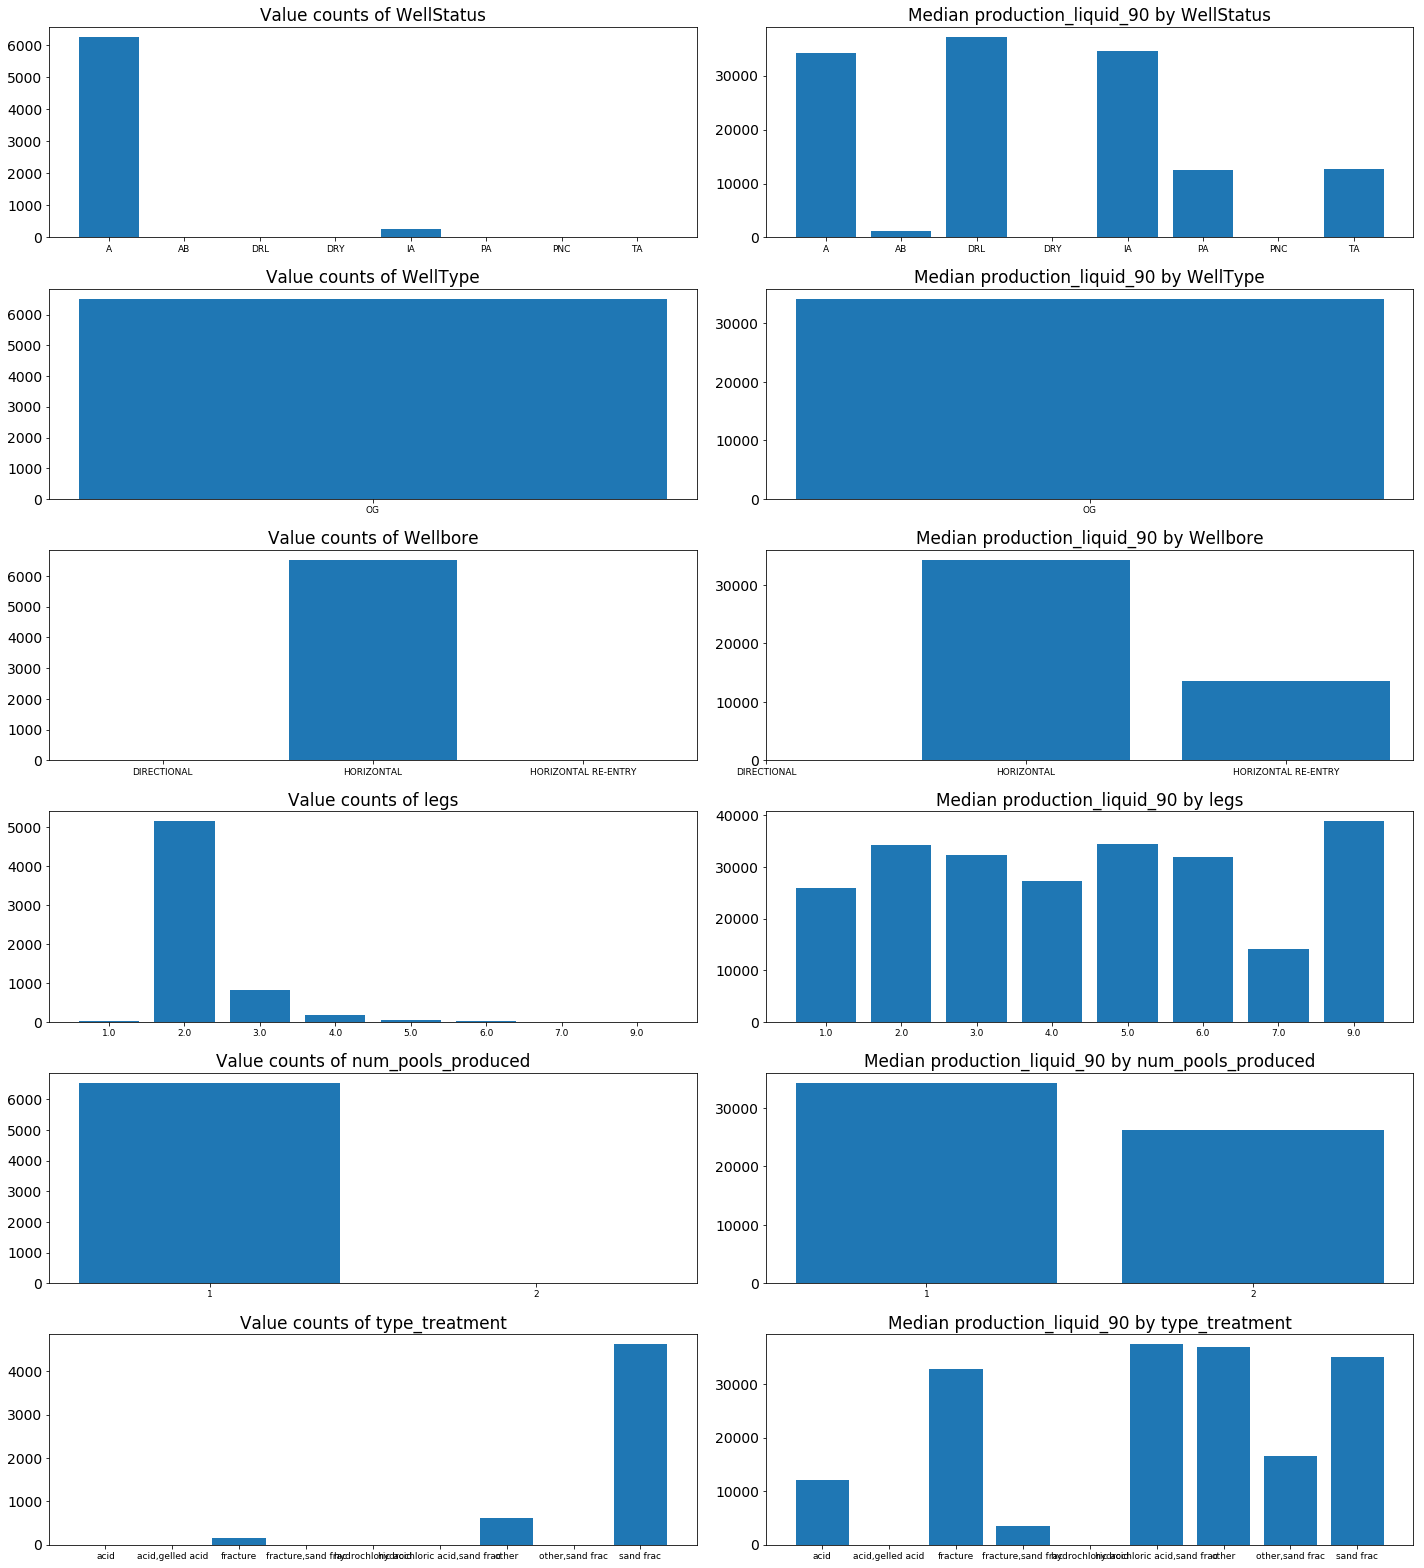

In [44]:
et.bar_plots(explore_df, list(categories), "production_liquid_90")

In [ ]:
explore_df.plot.scatter("KBElev", "GRElev", figsize=(16,8))

In [ ]:
fluid_and_proppant = explore_df[["total_volume_bbls", "total_lbs_proppant", ]]
fluid_and_proppant.head()

In [ ]:
from scipy import stats
fluid_and_proppant.dropna(inplace=True)

In [ ]:
fluid_and_proppant.plot.scatter("total_volume_bbls", "total_lbs_proppant", figsize=(16,8))

## This is interesting:
### should these be collapsed?

In [ ]:
fluid_and_proppant[(np.abs(stats.zscore(fluid_and_proppant)) < 3).all(axis=1)].plot.scatter("total_volume_bbls", "total_lbs_proppant", figsize=(16,8))

In [ ]:
plt.figure(figsize=(20,10)) 
plt.axis([-100000, 2e7, 0,161000])
plt.scatter(explore_df.total_lbs_proppant, explore_df.production_liquid_90)

In [ ]:
mport seaborn as sns

sns_plot = sns.pairplot(df, hue='species', size=2.5)
fig = sns_plot.get_figure()
fig.savefig("output.png")

## Possible data leakage
### ...Still, it works for now.

In [ ]:
munge_df = pd.concat([training_df, test_df])

## Datetime Stuff

In [ ]:
print "spud date NaNs: {}".format(munge_df.spud_date.isnull().sum())
print "well status date NaNs: {}".format(munge_df.well_status_date.isnull().sum())

In [ ]:
munge_df["spud_date"] = pd.to_datetime(munge_df["spud_date"], infer_datetime_format=True)

munge_df["spud_year"] = pd.DatetimeIndex(munge_df["spud_date"]).year

In [ ]:
munge_df["well_status_date"].head()

In [ ]:
munge_df["well_status_date"] = pd.to_datetime(munge_df["well_status_date"], infer_datetime_format=True)

munge_df["well_status_year"] = pd.DatetimeIndex(munge_df["well_status_date"]).year

In [ ]:
munge_df["well_status_year"].head()

In [ ]:
munge_df.well_status_date.dtypes

### Also an interesting plot. Target vs. well status date

In [ ]:
import datetime

In [ ]:
start = datetime.date(2006, 1, 1)
end = datetime.date(2015, 6, 1)

plt.figure(figsize=(20,10)) 
plt.axis([start, end, 0,161000])
plt.plot_date(munge_df["well_status_date"], munge_df["production_liquid_90"])


In [ ]:
start = datetime.date(2006, 1, 1)
end = datetime.date(2015, 6, 1)

plt.figure(figsize=(20,10)) 
plt.axis([start, end, 0,35000000])
plt.plot_date(munge_df["well_status_date"], munge_df["total_lbs_proppant"])


In [ ]:
plt.figure(figsize=(20,10))
plt.axis([start, end, start, end])
plt.plot_date(munge_df["spud_date"], munge_df["well_status_date"])

In [ ]:
munge_df["well_age"] = munge_df["well_status_date"] - munge_df["spud_date"]

I don't think this worked. Showing day of the month, rather than difference in days

In [ ]:
print munge_df.well_age.head()
munge_df.well_age = munge_df.well_age.dt.days
print munge_df.well_age.head()

In [ ]:
munge_df.well_age.describe()

In [ ]:
munge_df["well_age"]

In [ ]:
munge_df.well_age.plot.hist()

In [ ]:
my_blacklist_patterns = ['^recent_ipt_', '^production_', 'total_num_stages', 'bakken_isopach_ft']

In [ ]:
munge_df.drop(["api", "FileNo", "Section", "spud_date", "well_status_date"], axis=1, inplace=True)

In [ ]:
munged_df = dmt.munge_pipe(munge_df, blacklist_patterns=my_blacklist_patterns, exceptions=set([TARGET_1]), null_cutoff=.18)

### Split

In [ ]:
X, y = mft.X_y_split(munged_df, TARGET_1)

In [ ]:
y.isnull().sum()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df, test_df = train_test_split(munged_df)

In [ ]:
print munged_df.shape

In [ ]:
print train_df.shape

In [ ]:
print test_df.shape

In [ ]:
test_df[TARGET_1].isnull().sum()

In [ ]:
train_df[TARGET_1].isnull().sum()

In [45]:
from sklearn.ensemble import ExtraTreesRegressor

In [46]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np

x = explore_df["total_lbs_proppant"]
y = explore_df["total_volume_bbls"]
z = explore_df["spud_year"]


trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=10,
        color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='3d-scatter-colorscale')

ImportError: No module named plotly.plotly

In [ ]:
ExtraTreesRegressor(bootstrap=True, )